In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False); 
from IPython.display import Image

replicating local resources


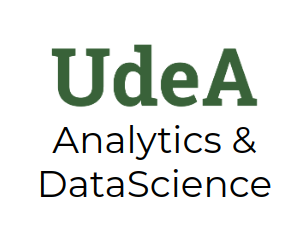

In [ ]:
Image("local/imgs/udea-datascience.png")

In [ ]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz 
!tar xf spark-3.0.1-bin-hadoop3.2.tgz 
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

#**MACHINE LEARNING**

El Machine Learning o aprendizaje automático es una disciplina orientada a crear sistemas que puedan aprender por sí solos, con el fin de extraer información no trivial de grandes volúmenes de datos por medio de la identificación de patrones complejos.

Spark implementa el aprendizaje automático a través del módlo MLLib que cuenta con un gran número de algoritmos que pue permiten crear modelos para el aprendizaje automático. Teniendo en cuenta que Spark proporciona sistemas distribuidos para trabajar en paralelo, los algoritmos de Machine Learning implementados en MLLib deben poder ser paralelizables

Pueden identificarse dos grandes ramas en el aprendizaje automático, a saber, el aprendizaje supervisado y el aprendizaje NO supervisado.



##**Preparación de Datos**

Para poder aplicar los métodos del aprendizaje supervisado y no supervisado, es necesario realizar una etapa previa de preparación de datos.

Esta etapa nos permite identificar y corregir posibles anomalías presentes en los datos y contribuir a la etapa de aprendizaje para obtener un buen resultado en la evaluación de los modelos.

###**Pasos**

Para la preparación de datos se recomienda realizar los siguientes pasos

**1. Identificación de variables**

* Propiedades del conjunto de datos
* Tipos de datos (verificar carga correcta de datos)


**2. Tratamiento de duplicados**

* Eliminar variables duplicadas (columnas)
* Eliminar registros duplicados (filas)
* Eliminar variables irrelevantes (ID, cedula, nombre, teléfono)


**3. Análisis univariable**

*  Variables numéricas: estadística descriptiva, histogramas, box plot
*  Variables categóricas: tabla de frecuencias y diagrama de barras


**4. Análisis bivariable**

* Correlaciones entre las variables predictoras deben ser menores a 0.7
* Correlaciones con la variable objetivo debe ser mayor a 0.3


**5. Tratamiento de outliers** (eliminar registros, eliminar variables, imputar, predecir)


**6. Tratamiento de datos nulos** (eliminar registros, eliminar variables, imputar o predecir)


**7. Transformación de variables desde las reglas del negocio**

* Discretización o Binning: convertir de número a categoría
* Crear variables Dummy: convertir de categoría a número


**8. Creación de variables** (fecha y otros)


**9. Reducción de variables** (en caso de ser necesario)


**10. Balanceo de la variable objetivo** (sólo en clasificación)


**11. Transformación datos para el método**

###**Pandas**

Veamos un ejemplo de cómo realizar estos pasos de la preparación de datos en un ambiente local utilizando pandas (no es un ambiente distribuido)

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

En el archivo aprobacion_curso.xlsx se encuentran los datos de estudiantes de un curso de universidad, para cada estudiante se tienen los siguientes datos:
* Id: Identificación del estudiante
* Año-Semestre: Momento en el que toma el curso
* Felder: Estilo de aprendizaje del estudiante
* Examen de admisión
* Nota final
* Aprobó: (Si/No)

**1.	Identificación de variables**
* Propiedades del conjunto de datos
* Tipos de datos (verificar carga correcta de datos)

In [ ]:
data = pd.read_excel("local/data/aprobacion_curso.xlsx",sheet_name=0) #leer la primera hoja del archivo
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.head()

,ID,Año - Semestre,Felder,Examen_admisión,Nota_final,Aprobo
0,1,2016-01,sensorial,4.67,3.1,si
1,2,2016-01,activo,4.17,2.1,no
2,3,2016-01,visual,4.50,3.1,si
3,4,2016-01,visual,3.83,1.6,no
4,5,2016-01,equilibrio,3.00,2.3,no


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               183 non-null    int64  
 1   Año - Semestre   183 non-null    object 
 2   Felder           183 non-null    object 
 3   Examen_admisión  181 non-null    float64
 4   Nota_final       183 non-null    float64
 5   Aprobo           183 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 8.7+ KB


Las variables tipo Object las convertimos a categorías

In [ ]:
data['Año - Semestre']=data['Año - Semestre'].astype('category')
data['Felder']=data['Felder'].astype('category')
data['Aprobo']=data['Aprobo'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               183 non-null    int64   
 1   Año - Semestre   183 non-null    category
 2   Felder           183 non-null    category
 3   Examen_admisión  181 non-null    float64 
 4   Nota_final       183 non-null    float64 
 5   Aprobo           183 non-null    category
dtypes: category(3), float64(2), int64(1)
memory usage: 5.8 KB


**2.	Tratamiento de duplicados**

* Eliminar variables duplicadas (columnas)
* Eliminar registros duplicados (filas)
* Eliminar variables irrelevantes (ID, cedula, nombre, teléfono)


**Variables Duplicadas:** Las variables Nota Final y Aprobó están duplicadas (representan la misma información), a partir de la nota final podemos saber si un estudiante aprueba o no el curso

In [ ]:
data = data.drop('Nota_final',axis=1)

**Registros duplicados:** Dos registros que tengan el mismo Id están duplicados

In [ ]:
data=data.drop_duplicates(['ID']) 

**Variables Irrelevantes**: Detectamos dos variables irrelevantes: Id y Año-Semestre

In [ ]:
data = data.drop('ID',axis=1)
data = data.drop('Año - Semestre',axis=1)

Así quedan los datos luego de este paso

In [ ]:
data.head()

**3.	Análisis univariable**

* Variables numéricas: estadística descriptiva, histogramas, box plot
* Variables categóricas: tabla de frecuencias y diagrama de barras


Variables numéricas

In [ ]:
data.describe() #Solo para datos numéricos

,Examen_admisión
count,181.000000
mean,3.826851
std,0.824674
min,0.000000
25%,3.500000
50%,3.830000
75%,4.330000
max,5.000000


In [ ]:
data.plot.box()

Variables categóricas

In [ ]:
pd.value_counts(data["Felder"])

In [ ]:
pd.value_counts(data["Aprobo"])

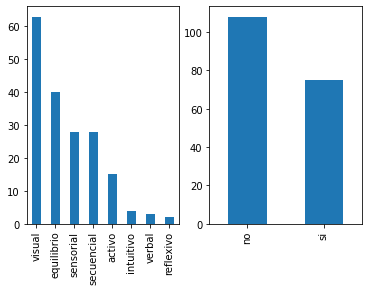

In [ ]:
plt.subplot(1,2,1)
pd.value_counts(data["Felder"]).plot(kind="bar")
plt.subplot(1,2,2)
pd.value_counts(data["Aprobo"]).plot(kind="bar")

**4.	Análisis bivariable**

* Correlaciones entre las variables predictoras deben ser menores a 0.7
* Correlaciones con la variable objetivo debe ser mayor a 0.3



In [ ]:
data.corr()

La correlación se aplica sobre variables numéricas, debemos convertir las variables categóricas a numéricas

In [ ]:
data_num=data #Hacemos una copia de los datos

dummiesFelder = pd.get_dummies(data['Felder'])  #Creamos variables dummy para convertir  las categorías a números
data_num = data_num.drop('Felder', axis=1)      #Elimino la columna original
data_num = data_num.join(dummiesFelder)         #Adiciono las dummies

data_num.head()

,Examen_admisión,Aprobo,activo,equilibrio,intuitivo,reflexivo,secuencial,sensorial,verbal,visual
0,4.67,si,0,0,0,0,0,1,0,0
1,4.17,no,1,0,0,0,0,0,0,0
2,4.50,si,0,0,0,0,0,0,0,1
3,3.83,no,0,0,0,0,0,0,0,1
4,3.00,no,0,1,0,0,0,0,0,0


In [ ]:
#Se codifican las categorias de la variable objetivo
data_num["Aprobo"]=data_num["Aprobo"].replace({"si": 1, "no": 0})
data_num.head()

Ahora nuestras variables son numéricas, ya podemos aplicar la correlación
* Correlación entre las variables predictoras debe ser menor de 0.7
* Correlación con la variable objetivo debe ser mayor a 0.3

In [ ]:
data_num.corr()

**5.	Tratamiento de outliers**
(eliminar registros, eliminar variables, imputar, predecir)



In [ ]:
data.describe()


Si un estudiante perdió el examen de admisión (nota<3) no debería estar en el curso

In [ ]:
data[data["Examen_admisión"]<3] #Consultamos los registros de los outliers
data1=data

In [ ]:
#Imputación por la media
media=data["Examen_admisión"].mean()
data.Examen_admisión[data["Examen_admisión"]<3]=media
data.describe()

**6.	Tratamiento de datos nulos** 
(eliminar registros, eliminar variables, imputar o predecir)



In [ ]:
data.info()

Hay dos registros con examen de admisión en null

In [ ]:
#Imputación por la media
data['Examen_admisión']=data['Examen_admisión'].fillna(value=data['Examen_admisión'].mean())
data.info()


**7.	Transformación de variables desde las reglas del negocio** 

* Discretización o Binning: convertir de número a categoría
* Crear variables Dummy: convertir de categoría a número


El examen de admisión que es una variable numérica, podríamos discretizarla para volverla categórica

In [ ]:
pd.cut(data["Examen_admisión"],3)

El estilo de aprendizaje que es una variable categórica, la podemos volver numérica

In [ ]:
pd.get_dummies(data['Felder']).head()

**8.	Creación de variables** 
(fecha y otros)



Como ejemplo podemos tomar una variable date time y extraer sus componentes

In [ ]:
from datetime import datetime

ahora = datetime.now()  # Obtiene fecha y hora actual
print("Fecha y Hora:", ahora)  # Muestra fecha y hora
print("Fecha y Hora UTC:",ahora.utcnow())  # Muestra fecha/hora UTC
print("Día:",ahora.day)  # Muestra día
print("Mes:",ahora.month)  # Muestra mes
print("Año:",ahora.year)  # Muestra año
print("Hora:", ahora.hour)  # Muestra hora
print("Minutos:",ahora.minute)  # Muestra minuto
print("Segundos:", ahora.second)  # Muestra segundo

**9.	Reducción de variables** 
(en caso de ser necesario)



Temporalmente eliminamos la variable objetivo para analizar solo las variables predictoras que son en las que debemos aplicar la reducción de variables

In [ ]:
X=data_num.drop('Aprobo', axis=1)
#Eliminamos los nulos en la variable Examen admision
X['Examen_admisión']=X['Examen_admisión'].fillna(value=X['Examen_admisión'].mean())
X.head()

PCA o análisis de componentes principales nos permite convertir nuestras variables originales en un nuevo y reducido grupo de variables que representen a los datos originales con una menor dimensión

In [ ]:
#Seleccionar la cantidad de componentes
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
#Aplicamos PCA para reducción de variables
pca = PCA(n_components=5)
principalComponents = pca.fit(X)
print("Componentes principales")
print(pca.components_)
print("Varianza acumulada")
varianza = pca.explained_variance_ratio_
var_acum= np.cumsum(varianza)
print(var_acum)


**10.	Balanceo de la variable objetivo**
(sólo en clasificación) 

In [ ]:
pd.value_counts(data["Aprobo"]).plot(kind="bar")

La variable objetivo (Aprobó) no cuenta con igual número de registros por categoría

In [ ]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(random_state=42, categorical_features=[0]) #sm = SMOTE(random_state=42) para datos sólo numéricos
X_bal, Y_bal = sm.fit_resample(data[['Felder', 'Examen_admisión']], data["Aprobo"])
# Creamos un dataframe con los resultados
data_bal = pd.DataFrame({"Felder": X_bal[:,0], "Examen_admisión":X_bal[:,1], "Aprobo": Y_bal})
# Veamos si ahora si está balanceado
pd.value_counts(data_bal["Aprobo"]).plot(kind="bar")

In [ ]:
#Guardamos los dataFrame preparados
data.to_excel('local/data/aprobacion_curso_pre.xlsx')
data_bal.to_excel('local/data/aprobacion_curso_bal.xlsx',sheet_name='Data_bal')

###**Spark**

Ahora veamos que nos ofrece Spark para realizar la preparación de datos en modo distribuido. Nos apoyaremos en los métodos de DataFrame y en la librería de Machine Learning

https://spark.apache.org/docs/latest/api/python/pyspark.ml.html

In [ ]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

In [ ]:
data = pd.read_excel("local/data/aprobacion_curso.xlsx",sheet_name=0)
estDF=sqlCtx.createDataFrame(data)
type(estDF)

pyspark.sql.dataframe.DataFrame

**Identificación de variables**
* Propiedades del conjunto de datos
* Tipos de datos (verificar carga correcta de datos)

In [ ]:
estDF.printSchema()
estDF.show(5)

root
 |-- ID: long (nullable = true)
 |-- Año - Semestre: string (nullable = true)
 |-- Felder: string (nullable = true)
 |-- Examen_admisión: double (nullable = true)
 |-- Nota_final: double (nullable = true)
 |-- Aprobo: string (nullable = true)

+---+--------------+----------+---------------+----------+------+
| ID|Año - Semestre|    Felder|Examen_admisión|Nota_final|Aprobo|
+---+--------------+----------+---------------+----------+------+
|  1|       2016-01| sensorial|           4.67|       3.1|    si|
|  2|       2016-01|    activo|           4.17|       2.1|    no|
|  3|       2016-01|    visual|            4.5|       3.1|    si|
|  4|       2016-01|    visual|           3.83|       1.6|    no|
|  5|       2016-01|equilibrio|            3.0|       2.3|    no|
+---+--------------+----------+---------------+----------+------+
only showing top 5 rows



En pandas nos muestra información sobre los registros que tienen valores null, DataFrames no nos muestra esa información y a demás las variables categóricas las trabajamos como String

**Tratamiento de duplicados**

* Eliminar variables duplicadas (columnas)
* Eliminar registros duplicados (filas)
* Eliminar variables irrelevantes (ID, cedula, nombre, teléfono)


In [ ]:
estDF=estDF.dropDuplicates(['ID'])
estDF=estDF.drop('ID','Año - Semestre','Nota_final')
estDF.printSchema()

root
 |-- Felder: string (nullable = true)
 |-- Examen_admisión: double (nullable = true)
 |-- Aprobo: string (nullable = true)



**Análisis univariable**

* Variables numéricas: estadística descriptiva, histogramas, box plot
* Variables categóricas: tabla de frecuencias y diagrama de barras


Variables numéricas

In [ ]:
estDF.select('Examen_admisión').describe().show()
estDF.select('Examen_admisión').distinct().show()

+-------+---------------+
|summary|Examen_admisión|
+-------+---------------+
|  count|            183|
|   mean|            NaN|
| stddev|            NaN|
|    min|            0.0|
|    max|            NaN|
+-------+---------------+

+---------------+
|Examen_admisión|
+---------------+
|            0.0|
|            3.5|
|           3.33|
|            NaN|
|            4.5|
|           4.33|
|           3.83|
|            1.0|
|           3.67|
|            4.0|
|           4.83|
|           4.67|
|            3.0|
|           4.17|
|           3.17|
|            5.0|
+---------------+



Encontró problemas con la variable examen de admisión, no puede calcular la estadística descriptiva de la variable hasta no resolver esos problemas

In [ ]:
estDF=estDF.fillna(3.0,'Examen_admisión')
estDF.select('Examen_admisión').describe().show()

+-------+------------------+
|summary|   Examen_admisión|
+-------+------------------+
|  count|               183|
|   mean|3.8178142076502732|
| stddev|0.8246481956629872|
|    min|               0.0|
|    max|               5.0|
+-------+------------------+



Variables categóricas

In [ ]:
estDF.groupBy('Felder').count().show()
estDF.groupBy('Aprobo').count().show()


+----------+-----+
|    Felder|count|
+----------+-----+
|equilibrio|   40|
|    activo|   15|
|    visual|   63|
| reflexivo|    2|
| sensorial|   28|
| intuitivo|    4|
|secuencial|   28|
|    verbal|    3|
+----------+-----+

+------+-----+
|Aprobo|count|
+------+-----+
|    si|   75|
|    no|  108|
+------+-----+



**Análisis bivariable**

* Correlaciones entre las variables predictoras deben ser menores a 0.7
* Correlaciones con la variable objetivo debe ser mayor a 0.3



La correlación se aplica sobre variables numéricas, debemos convertir las variables categóricas a numéricas

In [ ]:
estNum=estDF
estNum.select('Felder').distinct().show()

+----------+
|    Felder|
+----------+
|equilibrio|
|    activo|
|    visual|
| reflexivo|
| sensorial|
| intuitivo|
|secuencial|
|    verbal|
+----------+



In [ ]:
from pyspark.sql.types import *
estNum=estNum.\
  withColumn('equilibrio',(estNum.Felder=='equilibrio').cast(ByteType())).\
  withColumn('activo',(estNum.Felder=='activo').cast(ByteType())).\
  withColumn('visual',(estNum.Felder=='visual').cast(ByteType())).\
  withColumn('reflexivo',(estNum.Felder=='reflexivo').cast(ByteType())).\
  withColumn('sensorial',(estNum.Felder=='sensorial').cast(ByteType())).\
  withColumn('intuitivo',(estNum.Felder=='intuitivo').cast(ByteType())).\
  withColumn('secuencial',(estNum.Felder=='secuencial').cast(ByteType())).\
  withColumn('verbal',(estNum.Felder=='verbal').cast(ByteType())).\
  withColumn('AproboInt',(estNum.Aprobo=='si').cast(ByteType()))
estNum=estNum.drop('Felder','Aprobo')

estNum.printSchema()
estNum.show(5)

root
 |-- Examen_admisión: double (nullable = false)
 |-- equilibrio: byte (nullable = true)
 |-- activo: byte (nullable = true)
 |-- visual: byte (nullable = true)
 |-- reflexivo: byte (nullable = true)
 |-- sensorial: byte (nullable = true)
 |-- intuitivo: byte (nullable = true)
 |-- secuencial: byte (nullable = true)
 |-- verbal: byte (nullable = true)
 |-- AproboInt: byte (nullable = true)

+---------------+----------+------+------+---------+---------+---------+----------+------+---------+
|Examen_admisión|equilibrio|activo|visual|reflexivo|sensorial|intuitivo|secuencial|verbal|AproboInt|
+---------------+----------+------+------+---------+---------+---------+----------+------+---------+
|           3.33|         1|     0|     0|        0|        0|        0|         0|     0|        0|
|           4.33|         0|     0|     1|        0|        0|        0|         0|     0|        0|
|           4.83|         0|     0|     0|        0|        0|        0|         1|     0|       

Ahora nuestras variables son numéricas, ya podemos aplicar la correlación
* Correlación entre las variables predictoras debe ser menor de 0.7
* Correlación con la variable objetivo debe ser mayor a 0.3

Tenemos el método corr que calcula la correlación entre dos variables

In [ ]:
estNum.corr('equilibrio','activo')

-0.1580348853102535

La librería ml.stat cuenta con un método para calcular la correlación pero requiere definir los datos dentro de un vector

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=estNum.columns, outputCol=vector_col)
df_vector = assembler.transform(estNum).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

#visualize
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.        ,  0.08806434, -0.18838437,  0.11366537,  0.03415153,
        0.01072762, -0.03459361,  0.03583002, -0.42507384,  0.40969831,
        0.08806434,  1.        , -0.15803489, -0.38321423, -0.05559525,
       -0.22478905, -0.07906157, -0.22478905, -0.06827887, -0.03746275,
       -0.18838437, -0.15803489,  1.        , -0.21650635, -0.03140991,
       -0.12700013, -0.04466779, -0.12700013, -0.03857584, -0.04648111,
        0.11366537, -0.38321423, -0.21650635,  1.        , -0.07616499,
       -0.30795894, -0.10831364, -0.30795894, -0.09354143,  0.09775929,
        0.03415153, -0.05559525, -0.03140991, -0.07616499,  1.        ,
       -0.0446775 , -0.01571373, -0.0446775 , -0.01357063,  0.01927157,
        0.01072762, -0.22478905, -0.12700013, -0.30795894, -0.0446775 ,
        1.        , -0.06353553, -0.18064516, -0.05487033, -0.01467344,
       -0.03459361, -0.07906157, -0.04466779, -0.10831364, -0.01571373,
       -0.06353553,  1.        , -0.06353553, -0.01929869, -0.12

**Tratamiento de outliers**
(eliminar registros, eliminar variables, imputar, predecir)



Si un estudiante perdió el examen de admisión (nota<3) no debería estar en el curso

In [ ]:
prom=estNum.agg(functions.avg(estNum.Examen_admisión)).take(1)[0][0]
prom


3.8178142076502732

In [ ]:
estNum = estNum.withColumn('Examen_admisión', functions.when(estNum.Examen_admisión<3,prom)\
                                                 .when(estNum.Examen_admisión>=3, estNum.Examen_admisión))
estNum.describe().show()

+-------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|summary|   Examen_admisión|        equilibrio|             activo|            visual|          reflexivo|          sensorial|          intuitivo|         secuencial|             verbal|          AproboInt|
+-------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|  count|               183|               183|                183|               183|                183|                183|                183|                183|                183|                183|
|   mean|3.9111971094986413|0.2185792349726776|0.08196721311475409|0.3442622950819672|0.01092896174863388|0.15300546448087432|0.02185792349726776|0.15300546448087432|0.0163

**Transformación de variables desde las reglas del negocio** 

* Discretización o Binning: convertir de número a categoría
* Crear variables Dummy: convertir de categoría a número


El examen de admisión que es una variable numérica, podríamos discretizarla para volverla categórica

In [ ]:
from pyspark.ml.feature import QuantileDiscretizer

discretizer = QuantileDiscretizer(numBuckets=3, inputCol="Examen_admisión", outputCol="ExamenCat")

result = discretizer.fit(estNum).transform(estNum)
result.show()

+------------------+----------+------+------+---------+---------+---------+----------+------+---------+---------+
|   Examen_admisión|equilibrio|activo|visual|reflexivo|sensorial|intuitivo|secuencial|verbal|AproboInt|ExamenCat|
+------------------+----------+------+------+---------+---------+---------+----------+------+---------+---------+
|              3.33|         1|     0|     0|        0|        0|        0|         0|     0|        0|      0.0|
|              4.33|         0|     0|     1|        0|        0|        0|         0|     0|        0|      2.0|
|              4.83|         0|     0|     0|        0|        0|        0|         1|     0|        1|      2.0|
|               5.0|         0|     0|     1|        0|        0|        0|         0|     0|        1|      2.0|
|               5.0|         0|     0|     0|        0|        0|        0|         1|     0|        1|      2.0|
|              3.83|         1|     0|     0|        0|        0|        0|         0|  

**Reducción de variables** 
(en caso de ser necesario)



In [ ]:
# convert to vector column first
vector_col = "features"
assembler = VectorAssembler(inputCols=estNum.columns, outputCol=vector_col)
df_vector = assembler.transform(estNum).select(vector_col)

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=3, inputCol=vector_col, outputCol="pcaFeatures")
model = pca.fit(df_vector)
result = model.transform(df_vector).select("pcaFeatures")
result.show(truncate=False)

+--------------------------------------------------------------+
|pcaFeatures                                                   |
+--------------------------------------------------------------+
|[-2.6477136461772606,-1.1248151579012775,-1.1360582485536543] |
|[-3.684739767615163,-0.013090939723559458,-0.8405093709671235]|
|[-4.415889868565629,-1.163897987160901,0.1054187124903746]    |
|[-4.774426761979501,-0.21493717145033128,-0.6134481265397249] |
|[-4.552591203935235,-1.1968441698502104,0.0819714183129997]   |
|[-3.049776397264337,-1.2217156952227755,-1.20502087848711]    |
|[-3.0173156008106155,0.14776395223012717,-0.7260314052775868] |
|[-3.3231790680035496,-1.287608060601394,-1.2519154668418602]  |
|[-3.0183319730441975,-0.778116856823858,-0.45569295326179315] |
|[-4.541526142715751,-1.5204624642710454,-1.0469222639931672]  |
|[-3.7157551227140724,-0.8854241708818854,-0.16134980747745908]|
|[-3.0187380563714363,-0.8807106702086807,-0.13808795993542]   |
|[-3.1864777326339433,-1.

##**Aprendizaje Supervisado**

El aprendizaje supervisado utiliza un conjunto histórico de datos donde se tienen los registros previamente catalogados, para crear un modelo de predicción. Este modelo de predicción aprende de los datos históricos hasta obtener la capacidad de predecir lo que pasará con nuevos conjuntos de datos.

Se caracterizan por disponer de una variable objetivo o variable de clase, que es justamente lo que se quiere predecir. Esta variable objetivo puede ser numérica (regresión) o categórica (clasificación)

El **ciclo de vida** del aprendizaje supervisado consta de tres fases

* **Modelamiento:** Consiste en construir el modelo que permita predecir la variable objetivo
* **Evaluación:** Se evalúa el modelo predictivo construido para ver que tanto podemos confiar en el
* **Validación:** Una vez el modelo ha sido evaluado y el resultado es el esperado, se someten datos nuevos al modelo para realizar la predicción

La etapa de modelamiento y evaluación requieren del conjunto histórico de datos. Esto significa que debemos decidir la forma como se utilizarán los datos históricos en estas dos etapas. Para esto disponemos de tres opciones:

* Evaluar el mismo conjunto de entrenamiento
* División de datos (Split / 70-30)
* Validación cruzada

###**Predicción continua o Regresión**

Es el estudio de un conjunto de datos históricos con el fin de predecir un evento numérico futuro.

Es decir que la variable objetivo a predecir es de tipo numérica.

**Evaluación**

Como la variable a predecir es numérica el error de predicción se calcula al comparar el valor real contra el valor de la predicción y esto se hace con una fórmula matemática de cálculo de error. Existen varias formas de calcular ese error:

* Error medio absoluto:

$$error = \frac{\sum_ {i=1}^n  |f(x)-p(x)|}{n}$$

* Error cuadrático medio:
$$error = \frac{1}{n}\sum(f(x)-p(x))^2$$


Donde, 
* $f(x)$: Valor real
* $p(x)$: predicción

####**Regresión lineal**

Permite evaluar la relación entre una variable dependiente (variable a predecir) y un conjunto de variables independientes (variables predictoras)


$$Y = \alpha + \beta_1 X_1  +  \beta_2 X_2 + ... + \beta_n X_n + \epsilon$$

Donde,
* $Y$: Variable a predecir
* $X$: Variables predictoras (atributos)
* $\alpha$: Intercepto
* $\beta$: Pendiente
* $\epsilon$: Error

Básicamente lo que se hace es encontrar la ecuación de la recta que mejor represente al conjunto de datos, de modo que se pueda utilizar dicha ecuación para la predicción de nuevos registros




####**Árboles de decisión para regresión**

El método de árboles de decisión está disponible tanto para predecir números (árboles de regresión) como para predecir categorías (árboles de clasificación).

Su funcionamiento se basa en representar el conjunto histórico de datos a través de un árbol en el que tendremos dos componentes:
* Nodos: presentan una pregunta sobre algunos de los atributos y se genera una bifurcación a partir de la respuesta
* Hojas: Están al final de cada rama y son los valores de la predicción


Cuando se somete un registro al árbol de decisión, este recorre el árbol a través de las respuestas generadas en cada nodo, y al final llegará a una hoja que indica la predicción.

En el caso de los árboles de regresión, la variable a predecir es numérica, es decir que el resultado final de la predicción será un número 

###**Predicción discreta o Clasificación**

La clasificación permite predecir un evento numérico discreto, es decir que lo que pedimos ya no es un número sino una categoría, una cualidad.

Se utiliza el conjunto histórico de datos donde se cuenta con una variable objetivo que es de tipo categórica. Con ese histórico de datos, se crea un modelo que aprenderá de los datos y permitirá predecir datos futuros

**Evaluación**

Teniendo en cuenta que la variable objetivo es categórica, contamos con la clase real a la que pertenece cada uno de los registros que hacen parte del histórico de datos.

Por otro lado, el modelo arrojará como resultado una predicción sobre la clase a la que debe pertenecer cada registro. Usando la clase real y la predicción se construyen unas medidas de error que permiten evaluar la calidad del modelo. 

Estas medidas se construyen al identificar la cantidad de registros que quedaron clasificados correctamente es decir que la clase de la predicción y la clase real coinciden

Con esta información se construye lo que se conoce como matriz de confusión


In [ ]:
Image("local/imgs/matriz_confusion.png")

las cantidades relacionadas en la matriz de confusión nos permiten calcular esas medidas de error entre las cuales se destacan:

* Precisión: $$p=\frac{a}{a+b}$$
* Cobertura: $$r=\frac{a}{a+c}$$
* Exactitud: $$e=\frac{a+d}{a+b+c+d}$$
* Media armónica: $$f=\frac{2pr}{p+r}$$
* Razón de verdaderos positivos: $$VPR=\frac{a}{a+c}$$
* Razón de falsos positivos: $$FPR=\frac{b}{b+d}$$

Donde,

* $a$: Verdaderos positivos
* $b$: Falsos positivos
* $c$: Falsos negativos
* $d$: Verdaderos negativos

Con la razón de verdaderos positivos y la razón de falsos positivos se calcula el área ROC, medida utilizada ampliamente para evaluar modelos predictivos de clasificación.


####**Regresión Logística**

El funcionamiento es similar a la regresión lineal, donde se calculaba la ecuación de la recta que mejor represente al conjunto de datos con el fin de predecir una variable numérica.

La regresión logística aplica ese principio, pero teniendo en cuenta que la variable a predecir es categórica y puede tener n categorías,
lo que propone es calcular las ecuaciones de n rectas, una para cada categoría 

####**Árboles de decisión para clasificación**

El funcionamiento es similar a los árboles de regresión, solo que en este caso la variable a predecir es categórica.

A partir del conjunto histórico de datos se construye en árbol que tiene en sus nodos una pregunta sobre alguno de los atributos y en las hojas alguna de las categorías de la variable objetivo

####**Redes neuronales**

Las redes neuronales son modelos computacionales inspirados en sistemas biológicos, adaptados y simulados en computadoras convencionales. Buscan simular en un algoritmo la forma como se comportan las neuronas del cerebro humano.

Cada neurona tiene variables de entrada (atributos) que son multiplicados por un vector de pesos y el resultado es llevado a un mezclador lineal. A la salida del mezclador lineal se aplica una función de activación que puede ser tan sencilla o compleja como se quiera, el resultado es la salida de la neurona.

Las neuronas no trabajan solas, los resultados de cada neurona pueden ser llevados a varias neuronas que los utilizan como entradas. En este caso diremos que la red neuronal puede tener varias capas y dentro de cada capa se puede tener varias neuronas 

**Multilayer Perceptron**

Es una red neuronal con alimentación hacia adelante, compuesta de varias capas de neuronas entre la entrada y la salida de la misma, esta red permite establecer regiones de decisión mucho más complejas que las de dos semiplanos.

Como **función de activación** puede utilizar:
* Hardlim: Función escalón entre 0 y 1
* Hardlims: Función escalón simétrica entre -1 y 1

Multilayer perceptron utiliza la siguiente **regla de aprendizaje**:
* Pesos: $$w_{i+1} = w_i + (y_i - y_i')x_i $$
* Variable independiente: $$b_{i+1} = b_i + (y_i - y_i')$$

Donde,

* $w_{i+1}$: Peso de la neurona en la siguiente iteración
* $w_i$: Peso de la neurona en la iteración actual
* $y_i$: Salida real
* $y_i'$: Predicción
* $x_i$: Entrada actual de la neurona
* $b_{i+1}$: Entrada independiente en la siguiente iteración
* $b_i$: Entrada independiente en la iteración actual



####**Máquinas de Soporte Vectorial**

Las máquinas de soporte vectorial plantean la solución de un problema complejo (no separable linealmente) en un espacio de dimensión superior mediante la construcción de un hiperplano de separación óptima de clases.

El hiper plano construido permite separar a cada lado del mismo los registros de cada categoría de la variable objetivo.

Para representar los datos en una dimensión superior se utiliza la matriz de Kernel

####**Método Bayesiano**

Los métodos bayesianos utilizan el teorema de la probabilidad condicional de bayes: La probabilidad de que algo ocurra dado que ya han ocurrido ciertos sucesos.

La probabilidad de que un registro $reg$ pertenezca a la clase $C_j$ se calcula como:
$$P(C_j/reg) = \frac{P(C_j)P(reg/C_j)}{P(reg)}$$

Donde,

* $P(C_j)$: Probabilidad de la clase $C_j$
* $P(reg/C_j)$: Probabilidad de que la clase $C_j$ sea la clase del registro $reg$
* $P(reg)$: Probabilidad de seleccionar un registro

Naive Bayes implementa un método bayesiano asumiendo que los registros son independientes, con esto la probabilidad de que un registro $reg$ pertenezca a la clase $C_j$ se resume como:

$$P(C_j/reg) = P(C_j)P(reg/C_j)$$


Con los datos históricos se construye una tabla de probabilidades, que indica la probabilidad de que un registro pertenezca a cada una de las categorías de la variable objetivo

Dado un registro nuevo, la predicción consistirá en evaluar la probabilidad de pertenencia de dicho registro a cada una de las clases escogiendo aquella que cuente con la mayor probabilidad.

##**Aprendizaje NO Supervisado**

En el aprendizaje No Supervisado, NO se cuenta con datos históricos previamente etiquetados para la etapa de entrenamiento, en su lugar se dispone de datos actuales y lo que se haces es describir la estructura de esos datos actuales mediante un análisis exploratorio con el fin de facilitar el entendimiento de los datos.

###**Clustering**

Su objetivo es agrupar un conjunto de datos heterogéneo en grupos de datos homogéneos. En principio cada registro (fila) del conjunto de datos es diferente de los demás, por eso decimos que es heterogéneo, pero puede tener cierta similitud a un subconjunto de registros y es ahi donde se genera la agrupación, siendo cada subconjunto de datos (clúster) diferente a los demás subconjuntos.

La similaridad de los registros se expresa como una medida de distancia, de modo que un par de registros que se encuentre distante implicará que son diferentes, mientras que registros cercanos diremos que son similares

Dentro del **ciclo de vida** del Clustering se encuentran las siguientes etapas:
* Aprendizaje: Crear el modelo
* Evaluación: Evaluar el modelo
* Perfilamiento: Entender las características que definen a cada clúster (describir el centroide)


**Evaluación**

La evaluación del Clustering se basa en la comparación de dos medidas, estas medidas son:
* Cohesión o compacticidad: promedio de distancia de cada elemento a su centroide (distancia dentro del clúster)
* Separabilidad: promedio de distancias entre los centroides de los clústers (distancia entre clústers)

La comparación de estas dos medidas se expresa mediante índices, los mas conocidos son:

* Dunn
* Davies-Bouldin
* Silueta


####**K-means**

Divide el conjunto de datos en un número predefinido de grupos k. Es el método más comúnmente utilizado, la idea del método es definir k centroides, uno por clúster, y los datos son asociados al centroide más cercano.


#**Ejemplos**

##**Filtrado Colaborativo**

##**Clasificación**

##**Clustering**

#**Ejercicios**